In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from shapely.geometry import box, Point, Polygon, MultiPolygon
from shapely.wkt import loads
import networkx as nx
from geopy.distance import geodesic
import pickle


In [19]:
# lendo o arquivo .shp
caminho_shp = '../databases/paradas/paradas.shp'
df = gpd.read_file(caminho_shp)

In [20]:
# O folium trabalha no sistema WGS 84(EPSG:4326), o correto é converter para esse formato
df = df.to_crs('EPSG:4326')

In [21]:
# Lendo o arquivo das linhas
file = '../databases/linhas/Linhas.shp'
linhas = gpd.read_file(file)
linhas.head(5)
linhas.linha.shape[0]

1308

In [22]:
linestringRecanto = linhas[linhas['linha']=='0.813']
linestringRecantoIda = linestringRecanto.iloc[1] # ida
linestringRecantoVolta = linestringRecanto.iloc[0] # volta

In [23]:
# Verificando paradas proximas a linestring

paradas = gpd.read_file("../databases/paradas/paradas.shp")
paradas.tail(5)

,parada,descricao,situacao,estrutura_,tipo,geometry
5452,1163,NUCLEO RURAL RODEADOR - LADO OPOSTO ESCOLA ROD...,ATIVA,ACOSTAMENTO OU BAIA,Tipo C,POINT (167354.394 8264495.757)
5453,1164,NUCLEO RURAL RODEADOR - EM FRENTE ESCOLA RODEA...,ATIVA,ACOSTAMENTO OU BAIA,Tipo C,POINT (167311.355 8264500.454)
5454,1166,ANTES DA ENTRADA PARA A DF 445 NORTE - KM 7 DF...,ATIVA,SEM ESTRUTURA,Tipo C,POINT (163265.979 8265332.396)
5455,1159,LADO OPOSTO A ENTRADA DA RADIOBRAS E DF 220 DF...,ATIVA,SEM ESTRUTURA,Habitual,POINT (162912.871 8269061.030)
5456,6374,Km 07 - Gleba 02 - Chácara 116 - Chácara Beatr...,ATIVA,SEM ESTRUTURA,Padrão,POINT (163217.911 8264159.565)


In [24]:
# convertendo para o sistema adequado
paradas = paradas.to_crs('EPSG:4326')
paradas

,parada,descricao,situacao,estrutura_,tipo,geometry
0,6710,Avenida Morro da Cruz,DESATIVADA,SEM ESTRUTURA,Habitual,POINT (-47.76791 -15.91132)
1,6711,Avenida Morro da Cruz,DESATIVADA,SEM ESTRUTURA,Habitual,POINT (-47.76793 -15.91160)
2,6712,Avenida Morro da Cruz,DESATIVADA,SEM ESTRUTURA,Habitual,POINT (-47.76900 -15.91399)
3,6713,Avenida Morro da Cruz,DESATIVADA,SEM ESTRUTURA,Habitual,POINT (-47.76933 -15.91454)
4,6827,Residencial Vitoria,DESATIVADA,SEM ESTRUTURA,Habitual,POINT (-47.76832 -15.90857)
...,...,...,...,...,...,...
5452,1163,NUCLEO RURAL RODEADOR - LADO OPOSTO ESCOLA ROD...,ATIVA,ACOSTAMENTO OU BAIA,Tipo C,POINT (-48.10282 -15.67575)
5453,1164,NUCLEO RURAL RODEADOR - EM FRENTE ESCOLA RODEA...,ATIVA,ACOSTAMENTO OU BAIA,Tipo C,POINT (-48.10322 -15.67570)
5454,1166,ANTES DA ENTRADA PARA A DF 445 NORTE - KM 7 DF...,ATIVA,SEM ESTRUTURA,Tipo C,POINT (-48.14080 -15.66765)
5455,1159,LADO OPOSTO A ENTRADA DA RADIOBRAS E DF 220 DF...,ATIVA,SEM ESTRUTURA,Habitual,POINT (-48.14358 -15.63395)


In [25]:
import geopandas as gpd
from shapely.geometry import LineString, Point

# Criar o objeto Linestring
linestringRecanto = linestringRecanto.to_crs('EPSG:4326')

# Obter o objeto LineString a partir da coluna "geometry" do DataFrame
linestring = linestringRecanto.geometry.iloc[0]

# Lista para armazenar as paradas encontradas
paradas_encontradas = []

# Conjunto para armazenar os números das paradas encontradas
numeros_paradas_encontradas = set()

# Função para aproximar as coordenadas para 2 casas decimais
def aproximar_coordenadas(coord):
    return round(coord, 2)

# Iterar sobre os pontos de paradas e verificar se estão contidos na Linestring
for idx, ponto_parada in paradas.iterrows():
    numero_parada = ponto_parada["parada"]
    ponto = ponto_parada["geometry"]
    ponto_aproximado = Point(aproximar_coordenadas(ponto.x), aproximar_coordenadas(ponto.y))
    linestring_aproximada = LineString([Point(aproximar_coordenadas(x), aproximar_coordenadas(y)) for x, y in linestring.coords])
    if linestring_aproximada.contains(ponto_aproximado) and numero_parada not in numeros_paradas_encontradas:
        paradas_encontradas.append(ponto_parada)
        numeros_paradas_encontradas.add(numero_parada)

# Criar um novo GeoDataFrame com as paradas encontradas
gdf_paradas_encontradas = gpd.GeoDataFrame(paradas_encontradas, crs='EPSG:4326')


In [26]:
gdf_paradas_encontradas

,parada,descricao,situacao,estrutura_,tipo,geometry
69,3517,EQN 513/514 W3 NORTE,ATIVA,ACOSTAMENTO OU BAIA,Tradicional,POINT (-47.89601 -15.74749)
70,3473,SQN 113 EIXO W NORTE,ATIVA,ACOSTAMENTO OU BAIA,Tradicional,POINT (-47.88979 -15.74707)
494,3955,ENTRADA PARA Q. 508 CNJUNTOS 2. 3 E 3 AV. MONJOLO,ATIVA,SEM ESTRUTURA,Tipo C,POINT (-48.09974 -15.92356)
495,3946,LADO OPOSTO Q. 508 APOS ENTRADA DA RUA DO PARQ...,ATIVA,SEM ESTRUTURA,Tipo C,POINT (-48.09950 -15.92256)
496,3947,QUADRA 308 ANTES DA ENTRADA QUADRA 309 AV. MON...,ATIVA,SEM ESTRUTURA,Tipo C,POINT (-48.10099 -15.92465)
...,...,...,...,...,...,...
5292,3291,EQS 106/107 - Cine Brasília Eixo W Sul,ATIVA,ACOSTAMENTO OU BAIA,Cemusa,POINT (-47.89929 -15.81486)
5293,3343,EQS 106/107 - Cine Brasília Eixo W Sul,ATIVA,ACOSTAMENTO OU BAIA,Cemusa,POINT (-47.89912 -15.81473)
5300,3383,EQS 106/107 - CINE BRASILIA EIXO W SUL,ATIVA,ACOSTAMENTO OU BAIA,Fibra de Vidro,POINT (-47.89896 -15.81460)
5353,4723,APOS O VIADUTO DE ACESSO AO LAGO NORTE BR-020,ATIVA,SEM ESTRUTURA,Tipo C,POINT (-47.89611 -15.72536)


In [27]:
# Criar um grafo direcionado
G = nx.DiGraph()

# Adicionar nós para cada ponto de parada
for idx, ponto_parada in gdf_paradas_encontradas.iterrows():
    ponto = ponto_parada["geometry"]
    G.add_node(idx, pos=(ponto.y, ponto.x))  # Usar latitude (y) e longitude (x) como posição

# Adicionar arestas entre pontos de parada consecutivos
for i in range(len(gdf_paradas_encontradas)-1):
    ponto1 = gdf_paradas_encontradas.iloc[i]["geometry"]
    ponto2 = gdf_paradas_encontradas.iloc[i+1]["geometry"]
    distancia = geodesic((ponto1.y, ponto1.x), (ponto2.y, ponto2.x)).km
    G.add_edge(i, i+1, weight=distancia)  # Adicionar uma aresta para cada par de pontos consecutivos

print(G.nodes(data=True))  # Isso imprimirá todos os nós e seus atributos.

[(69, {'pos': (-15.747487243955707, -47.89600866323914)}), (70, {'pos': (-15.747074710133182, -47.889791802517124)}), (494, {'pos': (-15.923555471367532, -48.09974307423155)}), (495, {'pos': (-15.922556031085279, -48.099498770812595)}), (496, {'pos': (-15.924649134389988, -48.100989235742524)}), (497, {'pos': (-15.912965715195082, -48.0991417564201)}), (498, {'pos': (-15.914350055552772, -48.10134574919791)}), (499, {'pos': (-15.918457625116746, -48.10193728176956)}), (500, {'pos': (-15.921831326303028, -48.103734162546544)}), (501, {'pos': (-15.923482770153871, -48.104634244060826)}), (502, {'pos': (-15.923732177932882, -48.10436178761736)}), (503, {'pos': (-15.921286375823692, -48.10301513885338)}), (504, {'pos': (-15.91878145395848, -48.101702426843005)}), (505, {'pos': (-15.916169945218833, -48.099503742472415)}), (700, {'pos': (-15.903534453011293, -48.071709884449426)}), (701, {'pos': (-15.904556, -48.075886)}), (704, {'pos': (-15.905765859448325, -48.07850522929963)}), (705, {'p

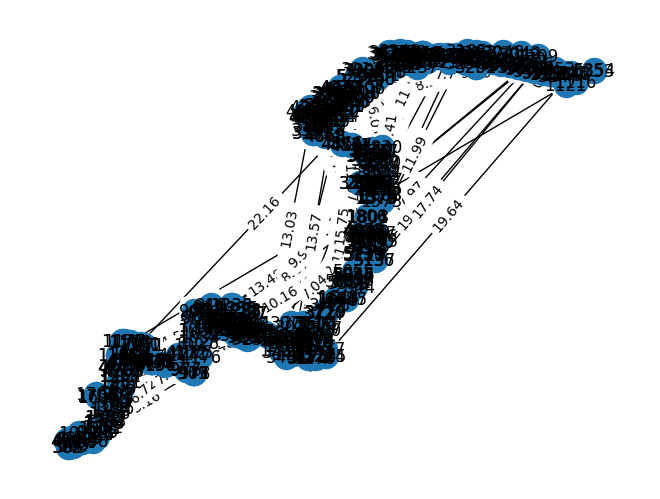

In [28]:
import networkx as nx
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Criar um grafo vazio
G = nx.Graph()

# Adicionar os nós ao grafo com os atributos de posição
nodes_data = [(69, {
    'pos': (-15.747487243955707, -47.89600866323914)
}), (70, {
    'pos': (-15.747074710133182, -47.889791802517124)
}), (494, {
    'pos': (-15.923555471367532, -48.09974307423155)
}), (495, {
    'pos': (-15.922556031085279, -48.099498770812595)
}), (496, {
    'pos': (-15.924649134389988, -48.100989235742524)
}), (497, {
    'pos': (-15.912965715195082, -48.0991417564201)
}), (498, {
    'pos': (-15.914350055552772, -48.10134574919791)
}), (499, {
    'pos': (-15.918457625116746, -48.10193728176956)
}), (500, {
    'pos': (-15.921831326303028, -48.103734162546544)
}), (501, {
    'pos': (-15.923482770153871, -48.104634244060826)
}), (502, {
    'pos': (-15.923732177932882, -48.10436178761736)
}), (503, {
    'pos': (-15.921286375823692, -48.10301513885338)
}), (504, {
    'pos': (-15.91878145395848, -48.101702426843005)
}), (505, {
    'pos': (-15.916169945218833, -48.099503742472415)
}), (700, {
    'pos': (-15.903534453011293, -48.071709884449426)
}), (701, {
    'pos': (-15.904556, -48.075886)
}), (704, {
    'pos': (-15.905765859448325, -48.07850522929963)
}), (705, {
    'pos': (-15.905478610060333, -48.07880978775035)
}), (706, {
    'pos': (-15.903887039812487, -48.07138779205818)
}), (707, {
    'pos': (-15.90440333257121, -48.075383581990195)
}), (708, {
    'pos': (-15.90475134526757, -48.075263090432585)
}), (811, {
    'pos': (-15.898841999999998, -48.055275)
}), (812, {
    'pos': (-15.898841999999998, -48.055275)
}), (813, {
    'pos': (-15.898928000000002, -48.055253)
}), (814, {
    'pos': (-15.898733, -48.054869)
}), (815, {
    'pos': (-15.898733, -48.054869)
}), (816, {
    'pos': (-15.898733, -48.054869)
}), (817, {
    'pos': (-15.898838355652625, -48.05526464032733)
}), (818, {
    'pos': (-15.898709949993485, -48.05487915994132)
}), (902, {
    'pos': (-15.867699286908332, -48.031872129100485)
}), (903, {
    'pos': (-15.870910182998015, -48.028681164016945)
}), (904, {
    'pos': (-15.874862615360769, -48.03234464047525)
}), (905, {
    'pos': (-15.867722551191601, -48.03240296677416)
}), (906, {
    'pos': (-15.872535720251461, -48.029875441297115)
}), (907, {
    'pos': (-15.87546998873825, -48.033746649855836)
}), (908, {
    'pos': (-15.876096193611582, -48.02930795061011)
}), (909, {
    'pos': (-15.872196498773105, -48.02948710262496)
}), (910, {
    'pos': (-15.869760346462686, -48.026133228477626)
}), (911, {
    'pos': (-15.87109001085548, -48.02829145528841)
}), (912, {
    'pos': (-15.87051198177733, -48.02713416318648)
}), (915, {
    'pos': (-15.850627304904341, -48.04152877478687)
}), (916, {
    'pos': (-15.85222529247888, -48.04075937532698)
}), (917, {
    'pos': (-15.851928133271286, -48.04033949037358)
}), (920, {
    'pos': (-15.855383761873233, -48.0442551302516)
}), (923, {
    'pos': (-15.855632132217814, -48.03889617952265)
}), (924, {
    'pos': (-15.854555467825396, -48.03895843059278)
}), (925, {
    'pos': (-15.856212668340392, -48.044590110478076)
}), (926, {
    'pos': (-15.86049252091362, -48.04229618449593)
}), (927, {
    'pos': (-15.862102632112045, -48.03989084096377)
}), (928, {
    'pos': (-15.857802079637423, -48.04376745208109)
}), (929, {
    'pos': (-15.860336137363651, -48.03888480366689)
}), (930, {
    'pos': (-15.860040306772095, -48.03908710260919)
}), (931, {
    'pos': (-15.859386229378819, -48.04022179531007)
}), (932, {
    'pos': (-15.85740079808935, -48.04126119869331)
}), (933, {
    'pos': (-15.857081727833732, -48.0429497379105)
}), (969, {
    'pos': (-15.876571999999996, -48.063367)
}), (971, {
    'pos': (-15.876099999999997, -48.063357)
}), (973, {
    'pos': (-15.87655977747654, -48.06336395666467)
}), (976, {
    'pos': (-15.879255754662887, -48.06173812022155)
}), (977, {
    'pos': (-15.879384751492381, -48.061146825969786)
}), (978, {
    'pos': (-15.876079537208987, -48.06336040064747)
}), (1001, {
    'pos': (-15.911888999999992, -48.094153)
}), (1002, {
    'pos': (-15.910957586862233, -48.09326934423694)
}), (1003, {
    'pos': (-15.911841259651768, -48.09406068191614)
}), (1023, {
    'pos': (-15.919610999999996, -48.096889)
}), (1024, {
    'pos': (-15.914083, -48.097389)
}), (1025, {
    'pos': (-15.912519701376944, -48.095946614091766)
}), (1026, {
    'pos': (-15.914072908245076, -48.09714676060153)
}), (1027, {
    'pos': (-15.876264185865082, -48.04798756342396)
}), (1028, {
    'pos': (-15.874567000000008, -48.046914)
}), (1029, {
    'pos': (-15.868968999999993, -48.038325)
}), (1030, {
    'pos': (-15.867329072372597, -48.03597347253602)
}), (1031, {
    'pos': (-15.874111394112967, -48.03750623028307)
}), (1032, {
    'pos': (-15.873542459479093, -48.041496705677105)
}), (1033, {
    'pos': (-15.874655767236849, -48.0394544647222)
}), (1034, {
    'pos': (-15.874219321801254, -48.04365980236096)
}), (1035, {
    'pos': (-15.868715241596034, -48.03799118569294)
}), (1036, {
    'pos': (-15.90683612725338, -48.0829242502795)
}), (1037, {
    'pos': (-15.90659112552102, -48.08117391153368)
}), (1109, {
    'pos': (-15.746633566629644, -47.888256593580245)
}), (1116, {
    'pos': (-15.732336825065836, -47.90264732277289)
}), (1121, {
    'pos': (-15.736023802288491, -47.9043530752539)
}), (1168, {
    'pos': (-15.900324751655013, -48.04634934801878)
}), (1174, {
    'pos': (-15.903393032996949, -48.045688090530795)
}), (1177, {
    'pos': (-15.90257542999361, -48.04563335714522)
}), (1178, {
    'pos': (-15.900703678903891, -48.04650972078287)
}), (1181, {
    'pos': (-15.904891999999997, -48.053322)
}), (1182, {
    'pos': (-15.899721999999995, -48.050583)
}), (1183, {
    'pos': (-15.904889732002081, -48.05331911017276)
}), (1184, {
    'pos': (-15.900040703978801, -48.051672440150796)
}), (1227, {
    'pos': (-15.856559000000006, -48.030314)
}), (1228, {
    'pos': (-15.858883000000008, -48.028999)
}), (1231, {
    'pos': (-15.856557371645883, -48.03029733859839)
}), (1232, {
    'pos': (-15.860230799859197, -48.027833761425924)
}), (1233, {
    'pos': (-15.862207617447972, -48.02600054550239)
}), (1234, {
    'pos': (-15.858823922319843, -48.02902627079976)
}), (1235, {
    'pos': (-15.85997913009943, -48.02765151770007)
}), (1236, {
    'pos': (-15.86199056459433, -48.02575459356673)
}), (1237, {
    'pos': (-15.856563634041699, -48.0300277144116)
}), (1238, {
    'pos': (-15.858571554331478, -48.02889942732971)
}), (1257, {
    'pos': (-15.9044180218172, -48.068197398424736)
}), (1258, {
    'pos': (-15.90429257982713, -48.06538186779065)
}), (1261, {
    'pos': (-15.90398476899251, -48.068530233891344)
}), (1262, {
    'pos': (-15.903880152435947, -48.0652975148702)
}), (1362, {
    'pos': (-15.88716655393049, -48.05902485881138)
}), (1363, {
    'pos': (-15.887040211574627, -48.05861497232256)
}), (1370, {
    'pos': (-15.896733208734803, -48.047546795116084)
}), (1371, {
    'pos': (-15.89517673226183, -48.04799566462771)
}), (1381, {
    'pos': (-15.896760907460926, -48.047762079104956)
}), (1383, {
    'pos': (-15.90959435740752, -48.09006943396089)
}), (1384, {
    'pos': (-15.910156000000002, -48.090839)
}), (1385, {
    'pos': (-15.907720278953988, -48.08402278176974)
}), (1386, {
    'pos': (-15.908115726395849, -48.085560172134066)
}), (1387, {
    'pos': (-15.909135010320384, -48.08785729601502)
}), (1388, {
    'pos': (-15.91026472965508, -48.09104949228238)
}), (1389, {
    'pos': (-15.909530868020195, -48.08802369672664)
}), (1390, {
    'pos': (-15.8612694963372, -48.03716939014417)
}), (1391, {
    'pos': (-15.862253000000003, -48.035317)
}), (1392, {
    'pos': (-15.862253000000003, -48.035317)
}), (1393, {
    'pos': (-15.860044000000002, -48.036017)
}), (1394, {
    'pos': (-15.855229685537482, -48.03584991887973)
}), (1395, {
    'pos': (-15.86002670586365, -48.036539976238394)
}), (1396, {
    'pos': (-15.862263392911801, -48.0353327357938)
}), (1397, {
    'pos': (-15.86004083249513, -48.03602391093067)
}), (1398, {
    'pos': (-15.858061909016195, -48.037094905619774)
}), (1401, {
    'pos': (-15.854963400819653, -48.03603758706459)
}), (1436, {
    'pos': (-15.892324406161302, -48.05735451335248)
}), (1437, {
    'pos': (-15.892341999999996, -48.057356)
}), (1438, {
    'pos': (-15.892341999999996, -48.057356)
}), (1439, {
    'pos': (-15.894924999999994, -48.056533)
}), (1440, {
    'pos': (-15.894557999999998, -48.056217)
}), (1441, {
    'pos': (-15.891674999999996, -48.057164)
}), (1442, {
    'pos': (-15.891674999999996, -48.057164)
}), (1443, {
    'pos': (-15.894912647994747, -48.056526373708984)
}), (1444, {
    'pos': (-15.89454093286884, -48.05621395775726)
}), (1445, {
    'pos': (-15.892066753113202, -48.05697748106128)
}), (1573, {
    'pos': (-15.805442000000001, -47.968435)
}), (1574, {
    'pos': (-15.80723039956119, -47.965717691510676)
}), (1575, {
    'pos': (-15.80778852625573, -47.96642705712294)
}), (1576, {
    'pos': (-15.807387213338785, -47.96643198290074)
}), (1577, {
    'pos': (-15.80753658912316, -47.96546680359306)
}), (1579, {
    'pos': (-15.807063277527064, -47.96682246252339)
}), (1583, {
    'pos': (-15.805457946420765, -47.96499610753198)
}), (1643, {
    'pos': (-15.82182694871858, -48.02169458840644)
}), (1644, {
    'pos': (-15.821860457646126, -48.021861664072624)
}), (1645, {
    'pos': (-15.818890999999997, -48.022389)
}), (1646, {
    'pos': (-15.822114555224573, -48.02306413226795)
}), (1647, {
    'pos': (-15.818916760403038, -48.02230916411662)
}), (1648, {
    'pos': (-15.822892558048778, -48.02257121141412)
}), (1699, {
    'pos': (-15.912435999999998, -48.076669)
}), (1703, {
    'pos': (-15.913105999999997, -48.075008)
}), (1704, {
    'pos': (-15.912758000000002, -48.076275)
}), (1705, {
    'pos': (-15.912758000000002, -48.076275)
}), (1706, {
    'pos': (-15.912758000000002, -48.076275)
}), (1723, {
    'pos': (-15.843727999999999, -48.044656)
}), (1724, {
    'pos': (-15.846471999999993, -48.043317)
}), (1725, {
    'pos': (-15.847763999999998, -48.043242)
}), (1726, {
    'pos': (-15.844236968163136, -48.044999551106486)
}), (1727, {
    'pos': (-15.842037930780156, -48.04545263132864)
}), (1728, {
    'pos': (-15.843726586976329, -48.0446454603338)
}), (1729, {
    'pos': (-15.843641730341833, -48.050672616995676)
}), (1731, {
    'pos': (-15.841647557265109, -48.04850884382321)
}), (1732, {
    'pos': (-15.842309313720737, -48.0435979277076)
}), (1733, {
    'pos': (-15.846480088238762, -48.043301708730446)
}), (1734, {
    'pos': (-15.84096211453132, -48.04677718477763)
}), (1735, {
    'pos': (-15.842104745598922, -48.04368357318204)
}), (1801, {
    'pos': (-15.811009250196394, -47.977077741767246)
}), (1803, {
    'pos': (-15.810399727114389, -47.977242251819966)
}), (1804, {
    'pos': (-15.810939720493455, -47.976921254720494)
}), (1806, {
    'pos': (-15.811162433255827, -47.97656494539353)
}), (1962, {
    'pos': (-15.86418041122397, -48.03612804912335)
}), (1963, {
    'pos': (-15.86475268049056, -48.03349066346261)
}), (1964, {
    'pos': (-15.864896202579391, -48.03823259805294)
}), (1965, {
    'pos': (-15.863687041721182, -48.03588725431338)
}), (1966, {
    'pos': (-15.865639938206881, -48.033526220197736)
}), (1967, {
    'pos': (-15.864804822951928, -48.03844669638399)
}), (1968, {
    'pos': (-15.863381825576003, -48.03422401439535)
}), (2381, {
    'pos': (-15.807851940323099, -47.96150790311419)
}), (2382, {
    'pos': (-15.808631527822117, -47.95823986090622)
}), (2383, {
    'pos': (-15.808795200905783, -47.957187265319384)
}), (2384, {
    'pos': (-15.808407149387623, -47.95770254569179)
}), (2385, {
    'pos': (-15.80906451022549, -47.95810068538549)
}), (2386, {
    'pos': (-15.811523165303319, -47.95825392427792)
}), (2387, {
    'pos': (-15.810698428427415, -47.957768027263334)
}), (2844, {
    'pos': (-15.815637869793536, -48.01590353723593)
}), (2910, {
    'pos': (-15.821642039849799, -47.91868013956277)
}), (2911, {
    'pos': (-15.825036171896743, -47.91760675040673)
}), (2912, {
    'pos': (-15.826588074640188, -47.91537404112989)
}), (2913, {
    'pos': (-15.826376387037772, -47.91508778790916)
}), (2917, {
    'pos': (-15.828097992359961, -47.91697065066023)
}), (2919, {
    'pos': (-15.82767331574554, -47.91685701332894)
}), (2920, {
    'pos': (-15.828897184716684, -47.91638020250634)
}), (2921, {
    'pos': (-15.828888492258761, -47.91587856121436)
}), (2922, {
    'pos': (-15.82113426291191, -47.918606667816576)
}), (3042, {
    'pos': (-15.752832495097259, -47.8862664341381)
}), (3048, {
    'pos': (-15.759514051257424, -47.885800698036114)
}), (3049, {
    'pos': (-15.753370470205146, -47.88777557822012)
}), (3052, {
    'pos': (-15.750807913099322, -47.8949281116755)
}), (3053, {
    'pos': (-15.753694998623457, -47.89400504430343)
}), (3054, {
    'pos': (-15.760012169623284, -47.891976176212104)
}), (3055, {
    'pos': (-15.757033653547683, -47.89293900668162)
}), (3056, {
    'pos': (-15.748203470810232, -47.89236463033028)
}), (3057, {
    'pos': (-15.750885974453999, -47.89150042029654)
}), (3058, {
    'pos': (-15.754208960654712, -47.89424438985205)
}), (3059, {
    'pos': (-15.75717373866217, -47.89329530076313)
}), (3060, {
    'pos': (-15.760465433818393, -47.89223559810704)
}), (3061, {
    'pos': (-15.750964679369993, -47.89528324932769)
}), (3075, {
    'pos': (-15.83963064531774, -48.03576499044226)
}), (3076, {
    'pos': (-15.837803694531415, -48.038145729306365)
}), (3077, {
    'pos': (-15.83509886213521, -48.035812654288875)
}), (3126, {
    'pos': (-15.780738695652959, -47.887459438755265)
}), (3130, {
    'pos': (-15.780964411486119, -47.887867366820046)
}), (3131, {
    'pos': (-15.780138703709568, -47.8912966316116)
}), (3132, {
    'pos': (-15.777867601935073, -47.88808519169229)
}), (3133, {
    'pos': (-15.777509708768566, -47.88773230535398)
}), (3170, {
    'pos': (-15.830146035926331, -48.05392406411004)
}), (3171, {
    'pos': (-15.8301156507609, -48.05246684266863)
}), (3172, {
    'pos': (-15.832741971607163, -48.05473862151782)
}), (3174, {
    'pos': (-15.833275909205058, -48.05495755348449)
}), (3175, {
    'pos': (-15.833174467927053, -48.054627700520754)
}), (3176, {
    'pos': (-15.83310664150534, -48.054410645447305)
}), (3177, {
    'pos': (-15.8302420119484, -48.053447828499074)
}), (3178, {
    'pos': (-15.830712212622913, -48.054961670743594)
}), (3179, {
    'pos': (-15.80164148572705, -47.89444234052956)
}), (3180, {
    'pos': (-15.803832548281662, -47.8968733783559)
}), (3181, {
    'pos': (-15.804051771822037, -47.89656602660574)
}), (3182, {
    'pos': (-15.767732515938105, -47.886153451016774)
}), (3183, {
    'pos': (-15.770042542792996, -47.885661821538555)
}), (3185, {
    'pos': (-15.773160019995464, -47.885123489955475)
}), (3248, {
    'pos': (-15.7986639371812, -47.88550509156002)
}), (3250, {
    'pos': (-15.773742411042742, -47.89197393309407)
}), (3251, {
    'pos': (-15.771152364468017, -47.88868146558276)
}), (3252, {
    'pos': (-15.770040305735364, -47.894303547524004)
}), (3253, {
    'pos': (-15.774801330614789, -47.88800228388125)
}), (3254, {
    'pos': (-15.766141701235163, -47.890017882666925)
}), (3255, {
    'pos': (-15.763216046795371, -47.89095602356193)
}), (3256, {
    'pos': (-15.769141094278112, -47.88915290178694)
}), (3257, {
    'pos': (-15.763359943029167, -47.89131190194332)
}), (3258, {
    'pos': (-15.766656694428423, -47.8902569120232)
}), (3259, {
    'pos': (-15.76925722178799, -47.88955468811846)
}), (3260, {
    'pos': (-15.771805359502322, -47.888934384031636)
}), (3261, {
    'pos': (-15.769798119995373, -47.894312239954715)
}), (3262, {
    'pos': (-15.7748788137897, -47.88843148773567)
}), (3263, {
    'pos': (-15.810923120761801, -47.99393122588247)
}), (3264, {
    'pos': (-15.810874260354762, -47.994095844937696)
}), (3265, {
    'pos': (-15.81135563337218, -47.99312039814935)
}), (3266, {
    'pos': (-15.81043429330682, -47.99378487965229)
}), (3286, {
    'pos': (-15.82359695827016, -47.9085261477033)
}), (3287, {
    'pos': (-15.822616612699811, -47.909890277068484)
}), (3288, {
    'pos': (-15.822546046115317, -47.9097949383633)
}), (3289, {
    'pos': (-15.823752282533526, -47.90874734893262)
}), (3290, {
    'pos': (-15.8239156270268, -47.90896931520181)
}), (3291, {
    'pos': (-15.824998989366408, -47.91096831458895)
}), (3293, {
    'pos': (-15.82376543603455, -47.91146322759282)
}), (3294, {
    'pos': (-15.82247044843861, -47.909678593009076)
}), (3295, {
    'pos': (-15.824199953684294, -47.911580882925236)
}), (3349, {
    'pos': (-15.831245175676612, -47.93082507806478)
}), (3350, {
    'pos': (-15.831160229311331, -47.92637327755652)
}), (3351, {
    'pos': (-15.831898528284261, -47.92886361730991)
}), (3352, {
    'pos': (-15.831449735020115, -47.93077003871413)
}), (3363, {
    'pos': (-15.813701427637834, -47.958248668848135)
}), (3366, {
    'pos': (-15.813633697369454, -47.95858828955789)
}), (3388, {
    'pos': (-15.817119684437223, -47.9130425169935)
}), (3389, {
    'pos': (-15.819241243681317, -47.91597920692626)
}), (3390, {
    'pos': (-15.817759322090723, -47.913306202798566)
}), (3391, {
    'pos': (-15.819700430682687, -47.91599181258493)
}), (3441, {
    'pos': (-15.842868355717547, -48.052148481726626)
}), (3444, {
    'pos': (-15.841423316465649, -48.05479385045358)
}), (3445, {
    'pos': (-15.838996140315949, -48.052734600967554)
}), (3460, {
    'pos': (-15.748031643828298, -47.89622512072298)
}), (3500, {
    'pos': (-15.828284000000004, -48.039561)
}), (3501, {
    'pos': (-15.83090131155041, -48.04334965991338)
}), (3502, {
    'pos': (-15.830763786421896, -48.0422543275836)
}), (3503, {
    'pos': (-15.829871688906936, -48.03584792707868)
}), (3504, {
    'pos': (-15.829843081637053, -48.03601408177246)
}), (3507, {
    'pos': (-15.827949283807861, -48.03863836404675)
}), (3509, {
    'pos': (-15.831442415527961, -48.043340394676505)
}), (3510, {
    'pos': (-15.830501476147262, -48.03612784915307)
}), (3511, {
    'pos': (-15.829370269549088, -48.03627266228225)
}), (3512, {
    'pos': (-15.830253840004191, -48.04243545913959)
}), (3514, {
    'pos': (-15.830729725082353, -48.04605381045298)
}), (3515, {
    'pos': (-15.8312520086486, -48.045936321652164)
}), (3516, {
    'pos': (-15.831385772840454, -48.04712784694789)
}), (3517, {
    'pos': (-15.826886, -48.04996)
}), (3518, {
    'pos': (-15.831621863021105, -48.04590691060566)
}), (3548, {
    'pos': (-15.80996243917798, -47.94087975358348)
}), (3549, {
    'pos': (-15.809360294301497, -47.94080047388728)
}), (3550, {
    'pos': (-15.808980396218939, -47.93940203467356)
}), (3551, {
    'pos': (-15.81060427583457, -47.943237032134896)
}), (3552, {
    'pos': (-15.811126276782945, -47.9434213732333)
}), (3553, {
    'pos': (-15.809269170774098, -47.94549015938696)
}), (3554, {
    'pos': (-15.808440252847607, -47.94549182148655)
}), (3555, {
    'pos': (-15.81007677335775, -47.942737543707516)
}), (3556, {
    'pos': (-15.810410040780853, -47.94271376174254)
}), (3620, {
    'pos': (-15.80175648254579, -47.88705482812118)
}), (3628, {
    'pos': (-15.802952205929643, -47.88628840887351)
}), (3629, {
    'pos': (-15.802514306391481, -47.885656757379195)
}), (3632, {
    'pos': (-15.802406616948419, -47.88712494032361)
}), (3719, {
    'pos': (-15.826678550804976, -48.02979222722242)
}), (3720, {
    'pos': (-15.8267213311457, -48.02997918843741)
}), (3724, {
    'pos': (-15.827731507263051, -48.03064285990589)
}), (3725, {
    'pos': (-15.82503406755004, -48.02605682549433)
}), (3727, {
    'pos': (-15.826437598051573, -48.030470541441645)
}), (3772, {
    'pos': (-15.795962090431319, -47.88598705610852)
}), (3807, {
    'pos': (-15.789610117742354, -47.88801486157596)
}), (3808, {
    'pos': (-15.788580267792598, -47.8895868114331)
}), (3809, {
    'pos': (-15.788523996195345, -47.89085345455449)
}), (3810, {
    'pos': (-15.790222882462139, -47.88629749039833)
}), (3811, {
    'pos': (-15.790210572683938, -47.886399800053695)
}), (3812, {
    'pos': (-15.78964022240059, -47.8906789716612)
}), (3813, {
    'pos': (-15.791051074978341, -47.886844986747825)
}), (3814, {
    'pos': (-15.787162382832602, -47.887918091709295)
}), (3815, {
    'pos': (-15.783898226654156, -47.88744731247922)
}), (3816, {
    'pos': (-15.78523008062385, -47.88797392390371)
}), (3817, {
    'pos': (-15.78989989281705, -47.88640286552865)
}), (3827, {
    'pos': (-15.80679919999488, -47.94064613995112)
}), (3830, {
    'pos': (-15.805304567052064, -47.93857339516827)
}), (3837, {
    'pos': (-15.806620504801717, -47.94708895567008)
}), (3839, {
    'pos': (-15.806542264172638, -47.94640904308206)
}), (3840, {
    'pos': (-15.805961903360432, -47.946980445069066)
}), (3845, {
    'pos': (-15.806959535016217, -47.99030831347626)
}), (3846, {
    'pos': (-15.807367327439957, -47.98750630910642)
}), (3847, {
    'pos': (-15.807591808880789, -47.98595722353355)
}), (3891, {
    'pos': (-15.808970894529612, -47.95407137683966)
}), (3894, {
    'pos': (-15.805742999999998, -47.951517)
}), (3898, {
    'pos': (-15.806933354308063, -47.953048727512936)
}), (3902, {
    'pos': (-15.80582922272832, -47.95151339713726)
}), (3908, {
    'pos': (-15.812212468938549, -47.895782896126086)
}), (3909, {
    'pos': (-15.811772228925648, -47.89570707366224)
}), (3913, {
    'pos': (-15.812946868945659, -47.895083454389116)
}), (4077, {
    'pos': (-15.812045403168122, -47.9853068924766)
}), (4078, {
    'pos': (-15.8121358352868, -47.98420389362696)
}), (4079, {
    'pos': (-15.8101, -47.9854)
}), (4080, {
    'pos': (-15.810089646617108, -47.985411222377884)
}), (4081, {
    'pos': (-15.811386355763252, -47.98524179360665)
}), (4082, {
    'pos': (-15.812547308562458, -47.98452296191304)
}), (4083, {
    'pos': (-15.810988454110761, -47.98630438343419)
}), (4084, {
    'pos': (-15.831520455197264, -47.92220430172252)
}), (4085, {
    'pos': (-15.834030340404404, -47.91832860572572)
}), (4086, {
    'pos': (-15.832406249936634, -47.916118057618895)
}), (4087, {
    'pos': (-15.830249317091392, -47.92050240989926)
}), (4088, {
    'pos': (-15.831295407289966, -47.91970518743446)
}), (4089, {
    'pos': (-15.83154931614379, -47.91950754389568)
}), (4090, {
    'pos': (-15.832769929092466, -47.92173656194267)
}), (4091, {
    'pos': (-15.832785017823277, -47.92128586964847)
}), (4092, {
    'pos': (-15.831983713753809, -47.92236524926379)
}), (4127, {
    'pos': (-15.848165938579161, -48.0428694822236)
}), (4130, {
    'pos': (-15.849616171149698, -48.04152319734663)
}), (4145, {
    'pos': (-15.811552946259352, -47.98888531456058)
}), (4146, {
    'pos': (-15.811477095014453, -47.98901499079689)
}), (4147, {
    'pos': (-15.810650226911248, -47.98874019291986)
}), (4148, {
    'pos': (-15.810972181854764, -47.98800076339249)
}), (4149, {
    'pos': (-15.81211452572845, -47.987833881684764)
}), (4150, {
    'pos': (-15.808780353879031, -47.991212429792114)
}), (4171, {
    'pos': (-15.878547712176404, -48.05289719400619)
}), (4172, {
    'pos': (-15.879045439663862, -48.05214416419446)
}), (4174, {
    'pos': (-15.882239104759606, -48.053626275167204)
}), (4175, {
    'pos': (-15.876972289105389, -48.05205061428754)
}), (4176, {
    'pos': (-15.873764109107045, -48.054374380272115)
}), (4200, {
    'pos': (-15.901938999999995, -48.058869)
}), (4201, {
    'pos': (-15.901506000000001, -48.056244)
}), (4202, {
    'pos': (-15.901506000000001, -48.056244)
}), (4203, {
    'pos': (-15.90324937694194, -48.06200257905907)
}), (4204, {
    'pos': (-15.90217438952289, -48.05847149849638)
}), (4205, {
    'pos': (-15.904430929993401, -48.06007398195004)
}), (4206, {
    'pos': (-15.901119281187693, -48.056252645117894)
}), (4207, {
    'pos': (-15.901926274765938, -48.05885181272419)
}), (4208, {
    'pos': (-15.90291768028956, -48.06211634596284)
}), (4210, {
    'pos': (-15.901517401438511, -48.056316032829415)
}), (4212, {
    'pos': (-15.904806777017628, -48.06023123575912)
}), (4236, {
    'pos': (-15.793956275876308, -47.88788699099974)
}), (4237, {
    'pos': (-15.792155358281045, -47.89410045390242)
}), (4238, {
    'pos': (-15.793771601562486, -47.88768710968123)
}), (4239, {
    'pos': (-15.793680473865013, -47.892767871060016)
}), (4255, {
    'pos': (-15.805870630776807, -47.96000921758504)
}), (4256, {
    'pos': (-15.805601662668343, -47.96186057500634)
}), (4262, {
    'pos': (-15.806206550995899, -47.95781933356454)
}), (4263, {
    'pos': (-15.806031138162092, -47.96125063779303)
}), (4299, {
    'pos': (-15.798380421975773, -47.892521340318204)
}), (4300, {
    'pos': (-15.79657539360549, -47.89113634914568)
}), (4301, {
    'pos': (-15.796571158659427, -47.89156399751735)
}), (4302, {
    'pos': (-15.796817015018108, -47.89167735948861)
}), (4303, {
    'pos': (-15.796440151869843, -47.89150734716131)
}), (4304, {
    'pos': (-15.800222344952411, -47.893789488241296)
}), (4305, {
    'pos': (-15.796693649729766, -47.89162232213451)
}), (4306, {
    'pos': (-15.798688809767597, -47.89017590146145)
}), (4307, {
    'pos': (-15.799530562485204, -47.888576396842346)
}), (4308, {
    'pos': (-15.798567538343542, -47.89219857275555)
}), (4309, {
    'pos': (-15.798423748559356, -47.88977093236863)
}), (4624, {
    'pos': (-15.838912999999996, -48.043433)
}), (4625, {
    'pos': (-15.83774191967895, -48.04848009733608)
}), (4626, {
    'pos': (-15.838326265933025, -48.047092368774756)
}), (4782, {
    'pos': (-15.823589739821033, -47.92137852239049)
}), (4783, {
    'pos': (-15.827904473149886, -47.92154415652659)
}), (4784, {
    'pos': (-15.823073205663594, -47.921288029206)
}), (4785, {
    'pos': (-15.825054283962409, -47.924030562027426)
}), (4786, {
    'pos': (-15.829108145486792, -47.92321783572998)
}), (4787, {
    'pos': (-15.825534276356807, -47.92407131326225)
}), (4865, {
    'pos': (-15.827876175327669, -47.9279248664852)
}), (4866, {
    'pos': (-15.820306548869024, -47.936330215467216)
}), (4867, {
    'pos': (-15.816759815678573, -47.93707549861569)
}), (4868, {
    'pos': (-15.826873388559667, -47.93258967811109)
}), (4869, {
    'pos': (-15.82709663490517, -47.93178785366626)
}), (4870, {
    'pos': (-15.826891875442579, -47.926576622944935)
}), (4871, {
    'pos': (-15.817131219352847, -47.93739848807652)
}), (4872, {
    'pos': (-15.820587243000409, -47.936671578989504)
}), (4873, {
    'pos': (-15.827472215930385, -47.92675051633629)
}), (4978, {
    'pos': (-15.821106124386226, -47.90557692441213)
}), (4979, {
    'pos': (-15.821104628932927, -47.90510375749437)
}), (4982, {
    'pos': (-15.819884871840875, -47.90606937026153)
}), (4984, {
    'pos': (-15.820312594080573, -47.9061856602494)
}), (5045, {
    'pos': (-15.81568094110479, -48.009432380794244)
}), (5046, {
    'pos': (-15.815971473098024, -48.00860988475326)
}), (5047, {
    'pos': (-15.816058132690555, -48.008993671247076)
}), (5051, {
    'pos': (-15.816938899045493, -48.01308003256529)
}), (5052, {
    'pos': (-15.818333818088373, -48.01385366245045)
}), (5053, {
    'pos': (-15.816381073766266, -48.00854664158798)
}), (5054, {
    'pos': (-15.818801610397436, -48.01236412556443)
}), (5055, {
    'pos': (-15.815865968177304, -48.00694724951823)
}), (5056, {
    'pos': (-15.815995519465774, -48.01206412435438)
}), (5057, {
    'pos': (-15.816121786666663, -48.01198390161794)
}), (5129, {
    'pos': (-15.811527314168332, -47.99801881597379)
}), (5130, {
    'pos': (-15.811990502106482, -47.99778057887483)
}), (5131, {
    'pos': (-15.811993934339025, -47.9979644761659)
}), (5135, {
    'pos': (-15.81208398731961, -47.99685032625128)
}), (5136, {
    'pos': (-15.8085162748691, -48.001110205279105)
}), (5137, {
    'pos': (-15.80813462503362, -48.000752700038575)
}), (5196, {
    'pos': (-15.808200459104249, -47.90064052596685)
}), (5200, {
    'pos': (-15.807984212354986, -47.90096608759629)
}), (5201, {
    'pos': (-15.806247857893846, -47.898621300099805)
}), (5206, {
    'pos': (-15.81170736531152, -47.90555987625302)
}), (5207, {
    'pos': (-15.811932091357574, -47.90526178698546)
}), (5208, {
    'pos': (-15.81387059690064, -47.90853860716472)
}), (5209, {
    'pos': (-15.815582610347516, -47.91091143488871)
}), (5210, {
    'pos': (-15.815806945688909, -47.91059247958316)
}), (5211, {
    'pos': (-15.813865081730327, -47.90790781376469)
}), (5214, {
    'pos': (-15.826673281589938, -48.054345168650286)
}), (5215, {
    'pos': (-15.826479019109609, -48.05394578528892)
}), (5242, {
    'pos': (-15.734075988598928, -47.897474410279735)
}), (5243, {
    'pos': (-15.73541921559784, -47.897317053648564)
}), (5246, {
    'pos': (-15.734639301086698, -47.897934702982674)
}), (5247, {
    'pos': (-15.738477194215498, -47.89929609836221)
}), (5249, {
    'pos': (-15.737021646013647, -47.89837691322528)
}), (5253, {
    'pos': (-15.740005369950573, -47.89508116855353)
}), (5255, {
    'pos': (-15.741101319354277, -47.898045528987495)
}), (5256, {
    'pos': (-15.741813505314967, -47.898220834748756)
}), (5269, {
    'pos': (-15.744737354143842, -47.89728338606178)
}), (5271, {
    'pos': (-15.744621728383612, -47.8969247962739)
}), (5292, {
    'pos': (-15.814863114617548, -47.89928668159575)
}), (5293, {
    'pos': (-15.814725253873776, -47.89911555821667)
}), (5300, {
    'pos': (-15.814598178878384, -47.898958156979326)
}), (5353, {
    'pos': (-15.725363381376555, -47.89610592172049)
}), (5354, {
    'pos': (-15.725204326671872, -47.895792118162866)
})]

for node_data in nodes_data:
    G.add_node(node_data[0], pos=node_data[1]['pos'])

# Adicionar as arestas ao grafo com os atributos de peso
# Este é apenas um exemplo, você precisa ajustá-lo para suas necessidades
for i in range(len(nodes_data) - 1):
    ponto1 = nodes_data[i][1]['pos']
    ponto2 = nodes_data[i + 1][1]['pos']
    distancia = geodesic(ponto1, ponto2).km
    G.add_edge(nodes_data[i][0], nodes_data[i + 1][0], weight=distancia)

# Obter uma lista de todos os nós presentes no grafo
node_list = G.nodes()

# Obter apenas as posições para os nós presentes no grafo
pos = nx.get_node_attributes(G, 'pos')
pos = {node: pos[node] for node in node_list if node in pos}

# Desenhar o grafo
nx.draw(G, pos, with_labels=True)

# Obter os rótulos das arestas e arredondar para duas casas decimais
labels = nx.get_edge_attributes(G, 'weight')
for key in labels:
    labels[key] = round(labels[key], 2)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()


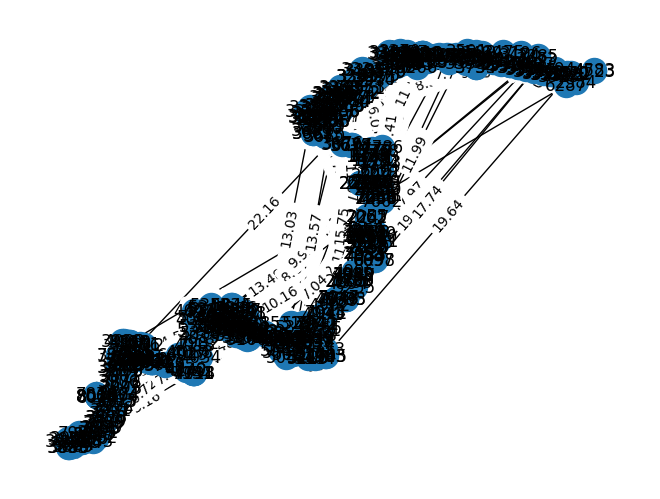

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import geopandas as gpd

# Criar um grafo vazio
G = nx.Graph()

# Adicionar os nós ao grafo com os atributos de posição
nodes_data = [(row['parada'], {'pos': (row['geometry'].y, row['geometry'].x)}) for index, row in gdf_paradas_encontradas.iterrows()]

for node_data in nodes_data:
    G.add_node(node_data[0], pos=node_data[1]['pos'])

# Adicionar as arestas ao grafo com os atributos de peso
# Este é apenas um exemplo, você precisa ajustá-lo para suas necessidades
for i in range(len(nodes_data) - 1):
    ponto1 = nodes_data[i][1]['pos']
    ponto2 = nodes_data[i+1][1]['pos']
    distancia = geodesic(ponto1, ponto2).km
    G.add_edge(nodes_data[i][0], nodes_data[i+1][0], weight=distancia)

# Obter uma lista de todos os nós presentes no grafo
node_list = G.nodes()

# Obter apenas as posições para os nós presentes no grafo
pos = nx.get_node_attributes(G, 'pos')
pos = {node: pos[node] for node in node_list if node in pos}

# Desenhar o grafo
nx.draw(G, pos, with_labels=True)

# Obter os rótulos das arestas e arredondar para duas casas decimais
labels = nx.get_edge_attributes(G, 'weight')
for key in labels:
    labels[key] = round(labels[key], 2)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()


In [30]:
# Salvando o grafo em um arquivo pickle
with open("meu_grafo.pkl", "wb") as file:
    pickle.dump(G, file)

In [31]:
# Carregando o grafo de um arquivo pickle
with open("meu_grafo.pkl", "rb") as file:
    G_loaded = pickle.load(file)

In [32]:
import json
from networkx.readwrite import json_graph

# Salvando o grafo em um arquivo JSON
data = json_graph.node_link_data(G)
with open("meu_grafo.json", "w") as file:
    json.dump(data, file)

# Carregando o grafo de um arquivo JSON
with open("meu_grafo.json", "r") as file:
    data = json.load(file)
G_loaded = json_graph.node_link_graph(data)

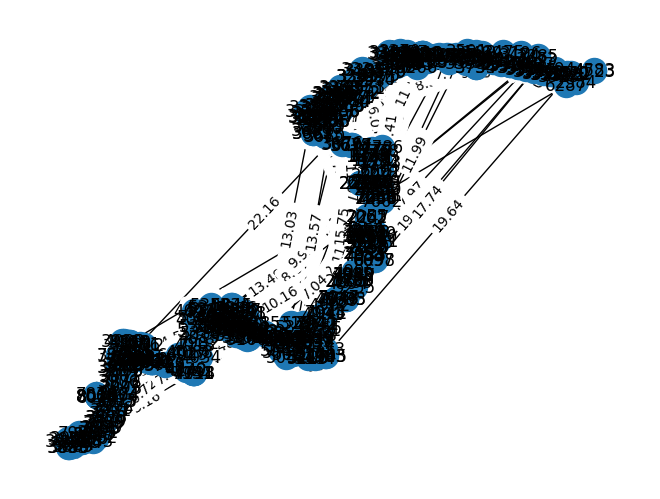

In [33]:
import matplotlib.pyplot as plt
import networkx as nx

# Carregando o grafo de um arquivo pickle
with open("meu_grafo.pkl", "rb") as file:
    G_loaded = pickle.load(file)

# Obter a posição dos nós
pos = nx.get_node_attributes(G_loaded, 'pos')

# Desenhar o grafo
nx.draw(G_loaded, pos, with_labels=True)

# Obter os pesos das arestas
labels = nx.get_edge_attributes(G_loaded, 'weight')

# Arredondar os pesos para duas casas decimais
for key in labels:
    labels[key] = round(labels[key], 2)

# Adicionar rótulos de peso às arestas
nx.draw_networkx_edge_labels(G_loaded, pos, edge_labels=labels)

# Exibir o grafo
plt.show()